Using device: cuda


Epoch 1/10 - Train Loss: 0.3066, Val Loss: 0.2753, LR: 0.000100
Best model updated!


Epoch 2/10 - Train Loss: 0.2609, Val Loss: 0.2790, LR: 0.000100
Backbone unfrozen, fine-tuning full model!


Epoch 3/10 - Train Loss: 0.2371, Val Loss: 0.2551, LR: 0.000100
Best model updated!


Epoch 4/10 - Train Loss: 0.2177, Val Loss: 0.2698, LR: 0.000100


Epoch 5/10 - Train Loss: 0.2027, Val Loss: 0.3016, LR: 0.000100


Epoch 6/10 - Train Loss: 0.1616, Val Loss: 0.2816, LR: 0.000050


Epoch 7/10 - Train Loss: 0.1419, Val Loss: 0.3075, LR: 0.000050


Epoch 8/10 - Train Loss: 0.1252, Val Loss: 0.3413, LR: 0.000050


Epoch 9/10 - Train Loss: 0.1196, Val Loss: 0.3295, LR: 0.000050
Early stopping triggered!


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 167/167 [02:40<00:00,  1.04it/s]


Mean IoU: 0.7221, Mean Dice: 0.8322, Pixel Accuracy: 0.8583


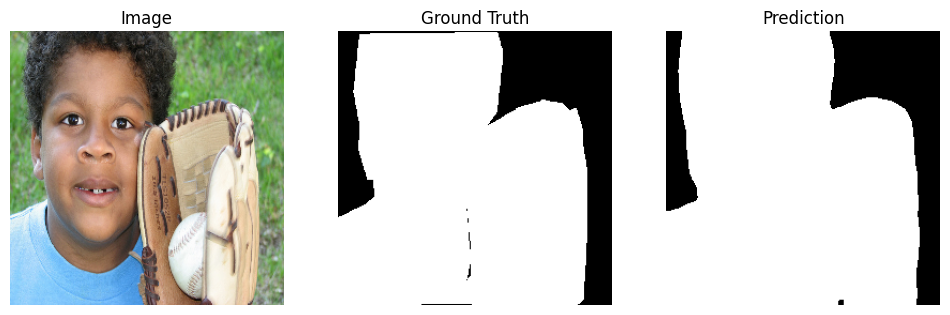

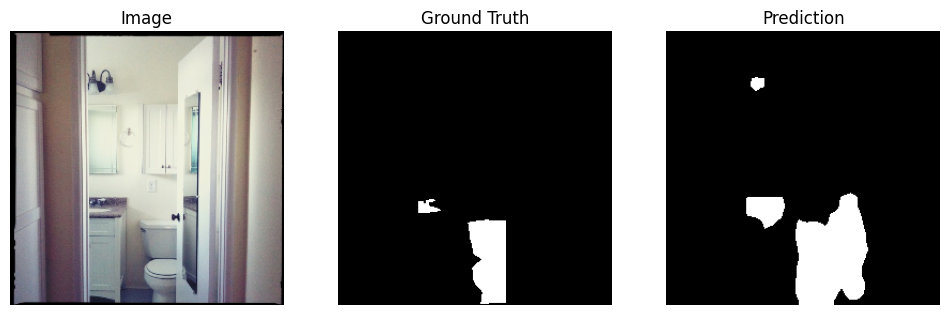

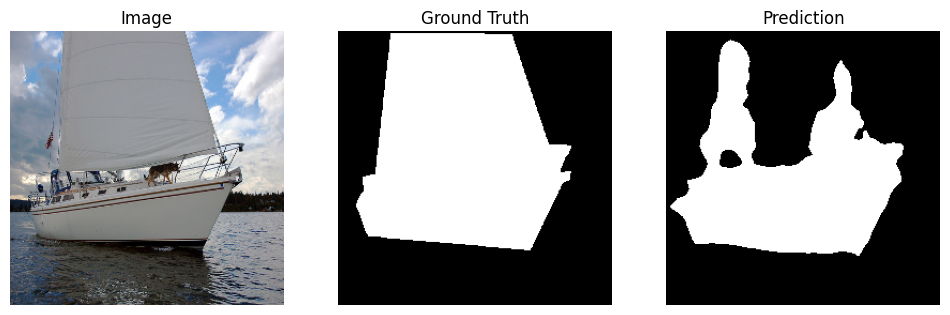

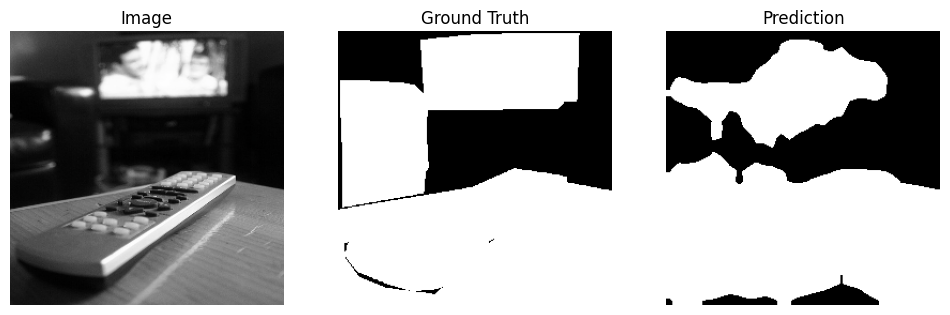

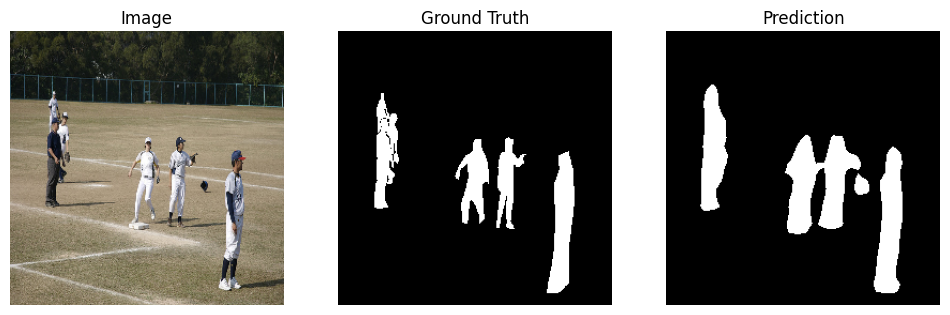

In [1]:
import os
import json
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from skimage.draw import polygon
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_epochs = 10
batch_size = 6
learning_rate = 1e-4
weight_decay = 1e-5
patience = 6
num_classes = 2
image_size = 256

class CocoMaskedDataset(Dataset):
    def __init__(self, images_path, annotations_path, transform=None):
        self.images_path = images_path
        self.transform = transform
        with open(annotations_path, "r") as f:
            coco = json.load(f)
        self.images = {img["id"]: img["file_name"] for img in coco["images"]}
        self.annotations = {}
        for ann in coco["annotations"]:
            img_id = ann["image_id"]
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_id = list(self.images.keys())[idx]
        img_path = os.path.join(self.images_path, self.images[img_id])
        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        anns = self.annotations.get(img_id, [])
        for ann in anns:
            for seg in ann["segmentation"]:
                if isinstance(seg, list) and len(seg) % 2 == 0:
                    poly = np.array(seg).reshape(-1, 2)
                    rr, cc = polygon(poly[:, 1], poly[:, 0], shape=img.shape[:2])
                    mask[rr, cc] = 1
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]
        return img, mask.long()

train_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.3),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

images_path = r"D:\val2017\val2017"
annotations_path = r"D:\annotations_trainval2017\annotations\instances_val2017.json"

dataset = CocoMaskedDataset(images_path, annotations_path, transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights, aux_loss=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model.to(device)

class_weights = torch.tensor([0.1, 0.9]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

def iou_score(preds, masks, num_classes=num_classes):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        ious.append((intersection / union).item() if union != 0 else float('nan'))
    return np.nanmean(ious)

def dice_score(preds, masks, num_classes=num_classes):
    preds = torch.argmax(preds, dim=1)
    dices = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        intersection = (pred_inds & target_inds).sum().float() * 2
        denominator = pred_inds.sum().float() + target_inds.sum().float()
        dices.append((intersection / denominator).item() if denominator != 0 else float('nan'))
    return np.nanmean(dices)

def pixel_accuracy(preds, masks):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == masks).sum().float()
    total = torch.numel(masks)
    return (correct / total).item()

def train_model(model, train_loader, val_loader, num_epochs=num_epochs, patience=patience):
    best_val_loss = float("inf")
    patience_counter = 0
    backbone_frozen = True
    best_model_wts = None
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Training]", leave=False):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [Validation]", leave=False):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)["out"]
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        
        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, "deeplabv3_best.pth")
            print("Best model updated!")
            patience_counter = 0
        else:
            patience_counter += 1
        
        if backbone_frozen and epoch >= 2:
            for param in model.backbone.parameters():
                param.requires_grad = True
            print("Backbone unfrozen, fine-tuning full model!")
            backbone_frozen = False
        
        scheduler.step()
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
    
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    return model

def evaluate_model(model, dataloader):
    model.eval()
    metrics = {"IoU": [], "Dice": [], "PixelAcc": []}
    with torch.no_grad():
        for imgs, masks in tqdm(dataloader, desc="Evaluating"):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)["out"]
            metrics["IoU"].append(iou_score(outputs, masks))
            metrics["Dice"].append(dice_score(outputs, masks))
            metrics["PixelAcc"].append(pixel_accuracy(outputs, masks))
    print(f"Mean IoU: {np.mean(metrics['IoU']):.4f}, Mean Dice: {np.mean(metrics['Dice']):.4f}, Pixel Accuracy: {np.mean(metrics['PixelAcc']):.4f}")

def visualize_predictions(model, dataloader, num_samples=5):
    model.eval()
    samples = 0
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)["out"]
            preds = torch.argmax(outputs, dim=1).cpu()
            for i in range(imgs.size(0)):
                img = imgs[i].cpu().permute(1, 2, 0).numpy()
                img = np.clip(img * (0.229,0.224,0.225) + (0.485,0.456,0.406), 0, 1)
                mask_gt = masks[i].cpu().numpy()
                mask_pred = preds[i].numpy()
                
                fig, axs = plt.subplots(1, 3, figsize=(12,4))
                axs[0].imshow(img); axs[0].set_title("Image"); axs[0].axis("off")
                axs[1].imshow(mask_gt, cmap="gray"); axs[1].set_title("Ground Truth"); axs[1].axis("off")
                axs[2].imshow(mask_pred, cmap="gray"); axs[2].set_title("Prediction"); axs[2].axis("off")
                plt.show()
                
                samples += 1
                if samples >= num_samples:
                    return

trained_model = train_model(model, train_loader, val_loader)
evaluate_model(trained_model, val_loader)
visualize_predictions(trained_model, val_loader, num_samples=5)
